In [1]:
# Imports
import os

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Resize, ToTensor
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

import pandas as pd
import numpy as np
import spacy
from collections import Counter
import matplotlib.pyplot as plt

import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Vocabulary Class

In [3]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}
    
    def __len__(self):
        return len(self.itos)

    # @staticmethod
    # def tokenizer_eng(text):
    #     return [tok.text.lower() for tok in spacy.load("en_core_web_sm").tokenizer(text)]
    
    @staticmethod
    def tokenizer_eng(text):
        return text.lower().strip().split()
    
    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = len(self.itos)

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text]

We will be using the Flickr8k dataset.

In [4]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=2):
        self.df = pd.read_csv(captions_file)
        self.root_dir = root_dir
        self.transform = transform

        self.imgs = self.df["image"].tolist()
        raw_captions = self.df["caption"].tolist()
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(raw_captions)

        # Preprocess all captions once
        self.captions = []
        for cap in raw_captions:
            tokens = [self.vocab.stoi["<SOS>"]]
            tokens += self.vocab.numericalize(cap)
            tokens.append(self.vocab.stoi["<EOS>"])
            self.captions.append(torch.tensor(tokens))

    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        caption = self.captions[idx]
        return img, caption

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def collate_fn(batch):
    images = []
    captions = []
    for img, cap in batch:
        images.append(img)
        captions.append(cap)
    
    images = torch.stack(images)
    captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=0)
    return images, captions

Modelle: ResNet50 for Image Feature Extraction and LSTM for language processing

In [6]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT) 
        for param in resnet.parameters():
            param.requires_grad = False
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
    
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        return self.fc(features)


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.init_h = nn.Linear(embed_size, hidden_size)
        self.init_c = nn.Linear(embed_size, hidden_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions[:, :-1])  # input tokens
        h0 = self.init_h(features).unsqueeze(0)  # (1, batch, hidden_size)
        c0 = self.init_c(features).unsqueeze(0)

        hiddens, _ = self.lstm(embeddings, (h0, c0))
        outputs = self.fc(hiddens)
        return outputs

Helper functions

In [7]:
# def train(model, dataloader, criterion, optimizer, vocab_size, num_epochs=5):
#     for epoch in range(num_epochs):
#         print(f"Start epoch {epoch}")
#         for idx, (imgs, captions) in enumerate(dataloader):
#             imgs, captions = imgs.to(device), captions.to(device)

#             features = encoder(imgs)
#             outputs = decoder(features, captions)

#             loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].reshape(-1))

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

In [8]:
def train(model, train_loader, val_loader, criterion, optimizer, vocab_size, num_epochs=5, patience=4):
    best_val_loss = float("inf")
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()
        total_train_loss = 0

        for idx, (imgs, captions) in enumerate(train_loader):
            imgs, captions = imgs.to(device), captions.to(device)

            features = encoder(imgs)
            outputs = decoder(features, captions)

            loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = validate(encoder, decoder, val_loader, criterion, vocab_size)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            torch.save({
                'encoder': encoder.state_dict(),
                'decoder': decoder.state_dict(),
                'optimizer': optimizer.state_dict()
            }, 'best_model.pth')
            print("New best model saved.")
        else:
            epochs_without_improvement += 1

        # Early stopping condition
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break


In [9]:
def validate(encoder, decoder, val_loader, criterion, vocab_size):
    encoder.eval()
    decoder.eval()

    total_loss = 0
    with torch.no_grad():
        for imgs, captions in val_loader:
            imgs, captions = imgs.to(device), captions.to(device)
            features = encoder(imgs)
            outputs = decoder(features, captions)
            loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].reshape(-1))
            total_loss += loss.item()
    
    encoder.train()
    decoder.train()
    return total_loss / len(val_loader)

In [10]:
def test(encoder, decoder, data_loader, vocab):
    encoder.eval()
    decoder.eval()

    references = []
    hypotheses = []

    for images, captions in data_loader:
        images = images.to(device)
        for i in range(len(images)):
            img = images[i]
            true_caption = captions[i]

            # remove <PAD>, <SOS>, <EOS>
            target_tokens = [vocab.itos[token.item()] for token in true_caption if token.item() not in [0, 1, 2]]
            references.append([target_tokens])

            # Predict caption
            #predicted_caption = caption_image(encoder, decoder, img, vocab)
            predicted_caption = caption_image_beam_search(encoder, decoder, img, vocab)
            
            predicted_tokens = predicted_caption.strip().split()
            hypotheses.append(predicted_tokens)
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=SmoothingFunction().method1)
    
    meteor = np.mean([meteor_score(ref, hyp) for ref, hyp in zip(references, hypotheses)])
    
    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")
    print(f"METEOR: {meteor:.4f}")
    
    encoder.train()
    decoder.train()

In [11]:
def caption_image(encoder, decoder, image, vocab, max_length=50):
    result_caption = []

    with torch.no_grad():
        x = encoder(image.unsqueeze(0).to(device))
        states = None
        word = torch.tensor([vocab.stoi["<SOS>"]]).to(device)

        for _ in range(max_length):
            embedding = decoder.embed(word).unsqueeze(1)
            hiddens, states = decoder.lstm(embedding, states)
            output = decoder.fc(hiddens.squeeze(1))
            predicted = output.argmax(1)

            word = predicted
            predicted_word = vocab.itos[predicted.item()]
            if predicted_word == "<EOS>":
                break
            result_caption.append(predicted_word)

    return " ".join(result_caption)

In [12]:
def caption_image_beam_search(encoder, decoder, image, vocab, max_length=50, beam_size=3):
    with torch.no_grad():
        encoder_out = encoder(image.unsqueeze(0).to(device))
        vocab_size = len(vocab)

        # Start with the SOS token
        sequences = [[list(), 0.0, encoder_out, None]]  # [tokens, score, features, (h, c)]

        for _ in range(max_length):
            all_candidates = []
            for seq, score, features, states in sequences:
                if len(seq) > 0 and seq[-1] == vocab.stoi["<EOS>"]:
                    all_candidates.append((seq, score, features, states))
                    continue

                prev_word = torch.tensor([seq[-1]] if seq else [vocab.stoi["<SOS>"]]).to(device)
                embedding = decoder.embed(prev_word).unsqueeze(1)

                if states is None:
                    h0 = decoder.init_h(features).unsqueeze(0)
                    c0 = decoder.init_c(features).unsqueeze(0)
                    states = (h0, c0)

                hiddens, new_states = decoder.lstm(embedding, states)
                output = decoder.fc(hiddens.squeeze(1))
                probs = torch.nn.functional.log_softmax(output, dim=1)

                topk_probs, topk_idx = probs.topk(beam_size)

                for i in range(beam_size):
                    next_seq = seq + [topk_idx[0][i].item()]
                    next_score = score + topk_probs[0][i].item()
                    all_candidates.append((next_seq, next_score, features, new_states))

            # Keep only top beam_size candidates
            ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
            sequences = ordered[:beam_size]

        final_seq = sequences[0][0]
        caption = [vocab.itos[idx] for idx in final_seq if idx not in {vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<PAD>"]}]
        return " ".join(caption)

Download Flickr8k dataset:
https://www.kaggle.com/datasets/adityajn105/flickr8k

Convert txt file to csv file. Goal is to use csv directly in the dataloader

In [13]:
# txt_path = "Flickr8k_text/captions.txt"
# csv_path = "Flickr8k_text/captions.csv"

In [14]:
# df = pd.read_csv(txt_path)
# df.to_csv(csv_path, index=False)

In [15]:
# def filter_existing_images(csv_path, image_dir, output_path):
#     df = pd.read_csv(csv_path)
#     df = df[df["image"].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))]
#     df.to_csv(output_path, index=False)
#     print(f"Saved filtered CSV to {output_path} with {len(df)} entries.")

# filter_existing_images(
#     csv_path="Flickr8k_text/captions.csv",
#     image_dir="Flickr8k_dataset",
#     output_path="Flickr8k_text/captions_filtered.csv"
# )

In [16]:
# Load dataset
dataset = FlickrDataset(
    root_dir="Flickr8k_dataset",
    captions_file="Flickr8k_text/captions_filtered.csv",
    transform=transform,
    freq_threshold = 1
)

In [17]:
# split dataset - 80% train, 10% val, 10% test
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [18]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=4)

In [19]:
# Hyperparameter
embed_size = 256
hidden_size = 512
vocab_size = len(dataset.vocab)
num_epochs = 50
patience = 4
learning_rate = 3e-4

# Models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)

# Optimizer & Loss
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
params = list(decoder.parameters()) + list(encoder.fc.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

# Training
train((encoder, decoder), train_loader, val_loader, criterion, optimizer, vocab_size, num_epochs, patience)

Epoch [1/50], Train Loss: 4.2763, Val Loss: 3.6531
New best model saved.
Epoch [2/50], Train Loss: 3.4439, Val Loss: 3.3237
New best model saved.
Epoch [3/50], Train Loss: 3.1403, Val Loss: 3.1290
New best model saved.
Epoch [4/50], Train Loss: 2.9173, Val Loss: 2.9877
New best model saved.
Epoch [5/50], Train Loss: 2.7369, Val Loss: 2.8848
New best model saved.
Epoch [6/50], Train Loss: 2.5785, Val Loss: 2.8119
New best model saved.
Epoch [7/50], Train Loss: 2.4373, Val Loss: 2.7475
New best model saved.
Epoch [8/50], Train Loss: 2.3076, Val Loss: 2.7057
New best model saved.
Epoch [9/50], Train Loss: 2.1889, Val Loss: 2.6743
New best model saved.
Epoch [10/50], Train Loss: 2.0770, Val Loss: 2.6530
New best model saved.
Epoch [11/50], Train Loss: 1.9671, Val Loss: 2.6335
New best model saved.
Epoch [12/50], Train Loss: 1.8645, Val Loss: 2.6288
New best model saved.
Epoch [13/50], Train Loss: 1.7662, Val Loss: 2.6187
New best model saved.
Epoch [14/50], Train Loss: 1.6724, Val Loss: 2.

Caption Generation

In [20]:
def show_caption(image_path, encoder, decoder, vocab, transform):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).to(device)

    #caption = caption_image(encoder, decoder, img_tensor, vocab)
    caption = caption_image_beam_search(encoder, decoder, img_tensor, vocab)
    
    plt.imshow(image)
    plt.title(caption)
    plt.axis("off")
    plt.show()

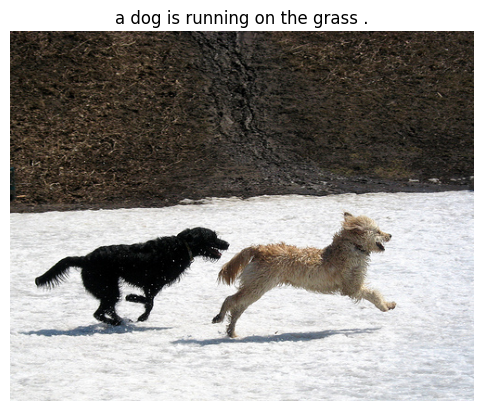

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Use picture from Flickr8k_Dataset
image_path = "Flickr8k_dataset/2513260012_03d33305cf.jpg"
show_caption(image_path, encoder, decoder, dataset.vocab, transform)

## Test model with metrics

Load best model

In [22]:
checkpoint = torch.load('best_model.pth', weights_only = True)
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

<All keys matched successfully>

In [23]:
test(encoder, decoder, test_loader, dataset.vocab)

BLEU-1: 0.3879
BLEU-4: 0.0860
METEOR: 0.3118
